<a href="https://colab.research.google.com/github/milindz/Food-Items-Classification/blob/main/Food_Classification(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Nov 30 13:00:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Introduction to transfer learning
> 🔑**Things we will be focussing in this notebook**:
1. Building a transfer learning feature extraction model using Tensorflow hub on a small subset of data (10% of training sample images)
2. Introduce Tensorboard callbacks and using Tensorboard to compare our models. 

In [2]:
# Getting data - 10% of all training samples
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-11-30 13:13:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 64.233.181.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   156MB/s    in 1.0s    

2021-11-30 13:13:47 (156 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
# Checking the image files in each folder
import os
for  dirpath,dirnames,filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)}files in {dirpath}")


There are 2 directories and 0files in /content/10_food_classes_10_percent
There are 10 directories and 0files in /content/10_food_classes_10_percent/train
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/pizza
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/hamburger
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/sushi
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/ramen
There are 0 directories and 75files in /content/10_food_classes_10_percent/train/steak
There are 0 directories and 75fi

Now, training directories have only 75 images rather than 750 images (10 % of train data). But, test directories have the same amount of data as we as in the previous notebook.

In [9]:
os.walk??

In [10]:
import tensorflow as tf

In [12]:
# Data Preprocessing using ImageDataGenerator class
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"


IMG_SHAPE = (224,224)


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size= 32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMG_SHAPE,
                                              batch_size= 32,
                                              class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [24]:
# Creating Tensorboard Callback function
import datetime
def tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name+ "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving log file to {log_dir}")
  return tensorboard_callback


In [14]:
# Getting access to pre_trained models using tensorflow hub

####  Model we will be using are-
1. ResNetV2 - a state of the art computer vision model 
2. EfficientNet - a state of the art computer vision 

In [15]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [16]:
#resnet50 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
#EfficientB0 feature vector
efficient_net_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [17]:
# Fucntion to create the models
def make_model(model_url,num_classes = 10):
  # Downloading model from the above url as saving it as a keras layer
  feature_vector_layer =  hub.KerasLayer(model_url,
                                         trainable = False,
                                         name = "feature_vector_layer",
                                         input_shape =  IMG_SHAPE+(3,))
  #Creating the model
  model = tf.keras.Sequential([
          feature_vector_layer,
          layers.Dense(num_classes, activation="softmax",name = "output_layer")                     
  ])

  return model
  

In [18]:
# Resnet model
resnet_model = make_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [28]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_vector_layer (Keras  (None, 2048)             23564800  
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
# Fitting the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [tensorboard_callback(dir_name="tensorboard_logs",
                                                                    experiment_name = "resnet50")])

Saving log file to tensorboard_logs/resnet50/20211130-143750
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.9082 - accuracy: 0.3773 - val_loss: 1.2141 - val_accuracy: 0.6160
Epoch 2/5
24/24 [==============================] - 22s 931ms/step - loss: 0.9037 - accuracy: 0.7347 - val_loss: 0.8860 - val_accuracy: 0.7120
Epoch 3/5
24/24 [==============================] - 22s 929ms/step - loss: 0.6246 - accuracy: 0.8280 - val_loss: 0.7548 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 22s 928ms/step - loss: 0.4804 - accuracy: 0.8867 - val_loss: 0.7080 - val_accuracy: 0.7688
Epoch 5/5
24/24 [==============================] - 22s 926ms/step - loss: 0.3822 - accuracy: 0.9240 - val_loss: 0.6744 - val_accuracy: 0.7804


Only after running for 5 epochs, the ResNetV250 feature extraction model was able to outperform the model we created in the previous notebook (Food_Classification(1)), achieving around 92% accuracy on the training set and nearly 79% accuracy on the test set.

In [26]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

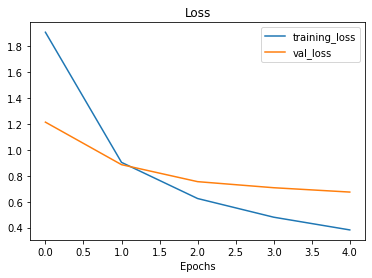

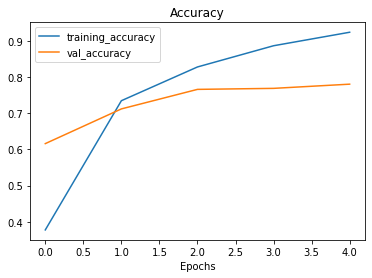

In [27]:
plot_loss_curves(resnet_history)

In [29]:
#EfficientNetB0 model
# Creating the model
efficient_net =  make_model(efficient_net_url,num_classes=train_data_10_percent.num_classes)

# Compile the model
efficient_net.compile(loss = "categorical_crossentropy",
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

In [32]:
efficient_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_vector_layer (Keras  (None, 1280)             4049564   
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [31]:
#Fitting the model
efficient_history =  efficient_net.fit(train_data_10_percent,
                                       epochs = 5,
                                       steps_per_epoch =  len(train_data_10_percent),
                                       validation_data =  test_data,
                                       validation_steps = len(test_data),
                                       callbacks = [tensorboard_callback(dir_name="tensorboard_logs",
                                                                         experiment_name = "efficient_net")])

Saving log file to tensorboard_logs/efficient_net/20211130-144856
Epoch 1/5
24/24 [==============================] - 34s 917ms/step - loss: 1.8304 - accuracy: 0.4333 - val_loss: 1.2818 - val_accuracy: 0.7196
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0507 - accuracy: 0.7667 - val_loss: 0.8599 - val_accuracy: 0.8184
Epoch 3/5
24/24 [==============================] - 20s 847ms/step - loss: 0.7561 - accuracy: 0.8373 - val_loss: 0.6972 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6061 - accuracy: 0.8693 - val_loss: 0.6097 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 19s 825ms/step - loss: 0.5149 - accuracy: 0.8880 - val_loss: 0.5580 - val_accuracy: 0.8584


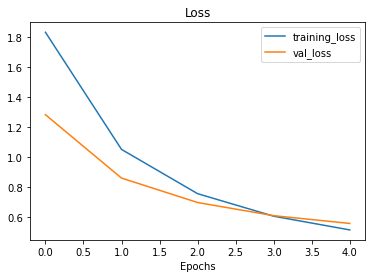

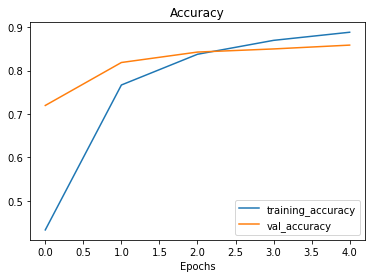

In [33]:
plot_loss_curves(efficient_history)

In [34]:
## Comapring models using tensorboard
## Uplaoding experiment to Tensorboard.dev
!tensorboard dev upload --logdir ./tensorboard_logs/ \
  --name "EfficientNetB0 vs. ResNet50V2" \  # experiment name
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot  # Exits the TensorBoardyu uploader once uploading is finished.


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=hxZzAqEqsBCQcxEMuRs90ilpSjy8JD&prompt=consent&access_type=o

In [35]:
!tensorboard dev list  #List out the experiments uploaded

https://tensorboard.dev/experiment/En8wWQtWRqyOxeXfDfWJGg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   En8wWQtWRqyOxeXfDfWJGg
	Created              2021-11-30 14:57:07 (2 minutes ago)
	Updated              2021-11-30 14:57:09 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5908558
Total: 1 experiment(s)


In [36]:
!tensorboard dev delete --experiment_id En8wWQtWRqyOxeXfDfWJGg

Deleted experiment En8wWQtWRqyOxeXfDfWJGg.


In [37]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
